## 6-3. Excited state search method (subspace-search variational quantum eigensolver)

As explained in [section 5-1](5.1_variational_quantum_eigensolver.ipynb), variational quantum eigensolver (VQE) is an algorithm for exploring the **ground state** of a quantum system. The ground state is an important state that determines the properties of various materials. There are phenomena such as photoresponse that are difficult to describe without using **excited states**.

Therefore, algorithms for creating excited-state wavefunctions on quantum computers are also being actively researched. Among them, I would like to introduce a new method proposed in 2018, Subspace-Search VQE (SSVQE) [1].

### Algorithm

The procedures of SSVQE are shown below.

1. Prepare $k$ initial states $\{|\varphi_i\rangle\}_{i=0}^{k-1}$ that are orthogonal to each other.
2. For each of them, apply a suitable quantum circuit $U(\theta)$ to generate the trial state $\{|\psi_i(\theta)\rangle \}_{i=0}^{k-1}$  (Note: $|\psi_i(\theta)\rangle = U(\theta)|\varphi_i\rangle$)
3. Tune $\theta$ to minimize the cost function $L(\theta) = \sum_i w_i \langle\psi_i(\theta)|H|\psi_i(\theta)\rangle$. where $w_i$ is chosen to be positive and $w_i<w_j$ for $i>j$.

When $U(\theta)$ has sufficient expressive power, $|\psi_i\rangle$ becomes the $i$-th excited state in converged $\theta$. This is because the global minimum point of the cost function is $|\psi_i\rangle = |E_i\rangle$, where $|E_i\rangle$ is the $i$-th excited state of the Hamiltonian. (See the original paper [1] for details.)

Below is an example of simulating SSVQE using Qulacs.

### SSVQE implementation

Implement SSVQE to search the ground state and the first excited state of the hydrogen molecule. If we treat the hydrogen molecule with the `sto-3g` minimal basis set, we get a 4-qubit Hamiltonian. Therefore, assuming the mutually orthogonal initial states $\{|\varphi_i\rangle\}_{i=0}^{1}$ required for SSVQE, we use one qubit flipped $|0000\rangle$ and $|0001\rangle$ .

* Note for those familiar with quantum chemistry: the first excited state here refers to the first excited state of the Hamiltonian of the hydrogen molecule without considering the number of electrons, which in chemical terms is the ground state of the hydrogen molecule ion.

#### Preparation of Hamiltonian

The Hamiltonian is calculated by PySCF + OpenFermion in the same procedure as last time. However, since excited states are also a problem in SSVQE, use `scipy.sparse.linalg.eigsh` to obtain the exact solution of the excited state.

In [ ]:
## Run if required libraries are not installed
## If you run on Google Colaboratory, igore the warning 'You must restart the runtime in order to use newly installed versions.'
## If you restart runtime, calculation may crash.
!pip install qulacs pyscf openfermion openfermionpyscf

## Run only in Google Colaboratory or (Linux or Mac) jupyter notebook environment
## Qulacs errors will be output normally.
!pip3 install wurlitzer
%load_ext wurlitzer

In [4]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator #If you have an error, please update openfermion later than version 1.0.0
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt

In [5]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
hamiltonian_matrix = get_sparse_operator(jw_hamiltonian)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(hamiltonian_matrix, k=2, which="SA")
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

#### preparation of ansatz

Let's compose a quantum circuit on Qulacs. Same as last time, the quantum circuits were modeled after those used in experiments with superconducting qubits (A. Kandala _et. al._ , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246).

In [6]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [7]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    circuit.add_gate(RY(0, theta_list[-2]))
    circuit.add_gate(RZ(0, theta_list[-1]))
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))
    
    return circuit

#### Define cost function of SSVQE

In [8]:
def get_exp(state, theta_list):
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #compose a quantum circuit
    circuit.update_quantum_state(state) #apply a quantum circuit to a state
    return qulacs_hamiltonian.get_expectation_value(state)

def cost(theta_list):
    state0 = QuantumState(n_qubit) #prepare |00000>
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #prepare |00001> 
    return get_exp(state0, theta_list)+0.5*get_exp(state1, theta_list)
    
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
cost(init_theta_list)

0.211562756558141

#### Execution of SSVQE

Now that we're ready, let's run SSVQE. For optimization, the BFGS method implemented in scipy is used, and the initial parameters are randomly selected. It should finish in tens of seconds.

In [10]:
exp_history0 = []
exp_history1 = []
def callback(theta_list):
    state0 = QuantumState(n_qubit) #prepare |0000> 
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #prepare |0001> 
    exp_history0.append(get_exp(state0, theta_list))
    exp_history1.append(get_exp(state1, theta_list))
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=callback)

Plotting the execution result, we can see that it has converged to the correct solution.

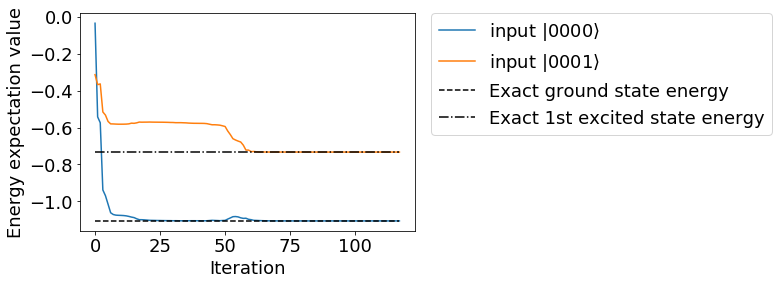

In [20]:
plt.rcParams["font.size"] = 18
plt.plot(exp_history0, label=r"input $|0000\rangle$")
plt.plot(exp_history1, label=r"input $|0001\rangle$")
plt.plot(range(len(exp_history0)), [molecule.fci_energy]*len(exp_history0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(exp_history1)), [eigval[1]]*len(exp_history1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

### Reference
[1] K. M Nakanishi, K. Mitarai, and K. Fujii, “Subspace-search variational quantum eigensolver for excited states”, Phys. Rev. Research 1, 033062 (2019),  https://arxiv.org/abs/1810.09434